In [2]:
%matplotlib inline
import json
#import plotly.express as px
#import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import pandas as pd
from statistics import mean, median, stdev, variance
import qgrid
from enum import Enum, IntEnum


import numpy as np
import pandas as pd
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.graph_objs as go
import chart_studio.plotly as py
import chart_studio
from plotly import tools

init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 100)

In [41]:
# folder paths
results_folder = 'data/benchmark/'
cnf_path = 'data/cnf-instances/'
wcnf_path = 'data/wcnf-instances/'



# problem names
# p = set(f_name for f_name in gurobi_ext4_files)
f_paths = None

# extension
if os.path.exists(results_folder):
    f_paths = [f"{results_folder}{f}" for f in os.listdir(results_folder) if f.endswith('.json')]
   
cnf_files = [f.replace('.cnf', '') for f in os.listdir(cnf_path) if f.endswith('.cnf')]
wcnf_files = [f.replace('.wcnf', '') for f in os.listdir(wcnf_path) if f.endswith('.wcnf')]

cnf_problems = [f for f in f_paths if any(cnf_file in f for cnf_file in cnf_files)]
wcnf_problems = [f for f in f_paths if any(wcnf_file in f for wcnf_file in wcnf_files)]
#print(f_paths)

In [42]:
class ClauseCounting(IntEnum):
    VALIDATED = 1
    WEIGHTS = 2
    WEIGHTED_UNASSIGNED = 3

class ClauseSorting(IntEnum):
    IGNORE = 0
    WEIGHTS = 1
    UNASSIGNED = 2
    WEIGHTED_UNASSIGNED = 3
    LITERAL_ORDERING = 4

class BestLiteral(IntEnum):
    COUNT_PURE_ONLY = 1
    COUNT_POLARITY = 2

class UnitLiteral(IntEnum):
    IGNORE = 0
    RANDOM = 1
    SINGLE_POLARITY = 2
    POLARITY = 3
    IMMEDIATE = 4

class SatModel(IntEnum):
    RANDOM = 1
    BEST_CLAUSES_VALIDATED = 2
    BEST_CLAUSE_WEIGHTS_COVERAGE = 3
    BEST_WEIGHTED_UNASSIGNED_CLAUSE_COVERAGE = 4
    ALL = 5



data = {'p':  [],
        'solver': [],
        'type':[],
        'clauses' : [],
        'steps': [],
        'total time [s]': [],
        '% hs [s]' : [],
        '% sat [s]' : [],
        '% grow [s]':[],
        's_hs':[],
        'nv':[],
        's_grow':[],
        'avg_s_hs':[],
        'avg_s_grow':[],
        'OMUS':[],
        "count_clauses": [],
        "best_unit_literal": [],
        "best_counter_literal": [],
        "sorting": [],
        "extension": [],
        "cutoff_main": [],
        "cutoff": [],
        "h_inc": [],
        "max_restart": [],
        "s_inc": [],
        "pb_restarts": [],
        "sp": [],
        "creation date": []
        }

for f_path in f_paths:
    p_name = f_path.replace('data/benchmark/','')
    data["creation date"].append(os.path.getctime(f_path))

    if f_path in cnf_problems:
        data['type'].append('cnf')
        data['p'].append([cnf_file for cnf_file in cnf_files if cnf_file in f_path][0])
    else:
        data['type'].append('wcnf')
        data['p'].append([wcnf_file for wcnf_file in wcnf_files if wcnf_file in f_path][0])

    with open(f_path) as f:
        parsed_json = json.load(f)
    if 'clauses' not in parsed_json:
        continue

    data['solver'].append('Gurobi')
    data['clauses'].append(parsed_json['clauses'])
    data['steps'].append(parsed_json['steps'])
    tot_time = sum(parsed_json['t_hitting_set']) +sum(parsed_json['t_sat_check'])  + sum(parsed_json['t_grow'])
    data['total time [s]'].append(tot_time)
    data['% hs [s]'].append(round(100*sum(parsed_json['t_hitting_set'])/tot_time, 2))
    data['% sat [s]'].append(round(100*sum(parsed_json['t_sat_check'])/tot_time,2))
    data['% grow [s]'].append(round(100*sum(parsed_json['t_grow'])/tot_time, 2))
    data['s_hs'].append(parsed_json['s_hs']),
    data['s_grow'].append(parsed_json['s_grow'])
    data['avg_s_hs'].append(round(mean(parsed_json['s_hs']), 2)),
    data['avg_s_grow'].append(round(mean(parsed_json['s_grow']),2))
    data['OMUS'].append(parsed_json['omus'])
    data['nv'].append(parsed_json['nv'])
    data["count_clauses"].append(parsed_json['parameters']["count_clauses"] if "count_clauses" in parsed_json['parameters'] else None)
    data["best_unit_literal"].append(parsed_json['parameters']["best_unit_literal"] if "best_unit_literal" in parsed_json['parameters'] else None)
    data["best_counter_literal"].append(parsed_json['parameters']["best_counter_literal"] if "best_counter_literal" in parsed_json['parameters'] else None)
    data["sorting"].append(parsed_json['parameters']["sorting"] if "sorting" in parsed_json['parameters'] else None)
    data["extension"].append(parsed_json['parameters']["extension"] if "extension" in parsed_json['parameters'] else None)
    data["cutoff_main"].append(parsed_json['parameters']["cutoff_main"] if "cutoff_main" in parsed_json['parameters'] else None)
    data["cutoff"].append(parsed_json['parameters']["cutoff"] if "cutoff" in parsed_json['parameters'] else None)
    data["h_inc"].append(parsed_json['parameters']["h_inc"] if "h_inc" in parsed_json['parameters'] else None)
    data["max_restart"].append(parsed_json['parameters']["max_restart"] if "max_restart" in parsed_json['parameters'] else None)
    data["s_inc"].append(parsed_json['parameters']["s_inc"] if "s_inc" in parsed_json['parameters'] else None)
    data["pb_restarts"].append(parsed_json['parameters']["pb_restarts"] if "pb_restarts" in parsed_json['parameters'] else None)
    data["sp"].append(parsed_json['parameters']["sp"] if "sp" in parsed_json['parameters'] else None)


data["count_clauses"] = [ None if val == None else next(name for name, value in vars(ClauseCounting).items() if value == int(val)) for val in data["count_clauses"]]
data["best_unit_literal"]  = [ None if val == None else next(name for name, value in vars(UnitLiteral).items() if value == int(val)) for val in data["best_unit_literal"]]
data["best_counter_literal"] = [ None if val == None else next(name for name, value in vars(BestLiteral).items() if value == int(val)) for val in data["best_counter_literal"]]
data["sorting"] = [ None if val == None else next(name for name, value in vars(ClauseSorting).items() if value == int(val)) for val in data["sorting"]]
    
ignored_columns = ['solver']

df = pd.DataFrame (data, columns = [column for column in data if column not in ignored_columns])
df.sort_values(['p','type','clauses','nv','OMUS',"count_clauses","best_unit_literal",
                "best_counter_literal","sorting","extension","creation date"],
                ascending = (True, True, True, True,True, True, True, True, True, True, False), inplace = True) 
df.drop_duplicates( ['p','type','clauses','nv','OMUS',"count_clauses","best_unit_literal",
                "best_counter_literal","sorting","extension","creation date"], keep='first', inplace = True)
df = df.sort_values(["clauses", "steps", "total time [s]"], ascending = (False, True, True))
qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# instances solved
df_solved = df[(df.OMUS == True)]
# instances solved without local search instances (because they mostly take too long on grow algorithm)
df_solved_no_ls = df_solved[(df_solved.extension !='satlike')]

# instances not solved 
df_unsolved = df[(df.OMUS == False)]
# instances not solved without local search instances (because they mostly take too long on grow algorithm)
df_unsolved_no_ls = df_unsolved[(df_unsolved.extension != 'satlike')]

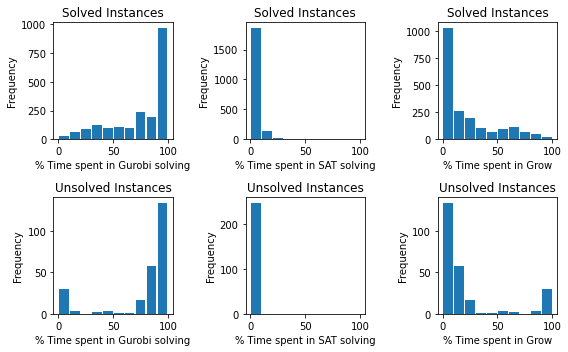

In [10]:
fig = plt.figure(figsize=(8,5))
y_label = "Frequency"
# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(231)
ax1.set_xlabel("% Time spent in Gurobi solving")
ax1.set_ylabel(y_label)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(232)
ax2.set_xlabel("% Time spent in SAT solving")
ax2.set_ylabel(y_label)

# Divide the figure into a 1x2 grid, and give me the second section
ax3 = fig.add_subplot(233)
ax3.set_xlabel("% Time spent in Grow")
ax3.set_ylabel(y_label)

# Divide the figure into a 1x2 grid, and give me the first section
ax4 = fig.add_subplot(234)
ax4.set_xlabel("% Time spent in Gurobi solving")
ax4.set_ylabel(y_label)


# Divide the figure into a 1x2 grid, and give me the second section
ax5 = fig.add_subplot(235)
ax5.set_xlabel("% Time spent in SAT solving")
ax5.set_ylabel(y_label)
# Divide the figure into a 1x2 grid, and give me the second section
ax6 = fig.add_subplot(236)
ax6.set_xlabel("% Time spent in Grow")
ax6.set_ylabel(y_label)

axs=[ax1, ax2, ax3, ax4, ax5, ax6]
solved_axs = [ax1, ax2, ax3]
unsolved_axs = [ax4, ax5, ax6]

df_solved_no_ls.hist(
    column='% hs [s]', 
    bins=10, 
    ax = ax1,
    grid=False, 
    range = (0, 100),
    rwidth=0.9,
    )

df_solved_no_ls.hist(
    column='% sat [s]', 
    bins=10, 
    ax = ax2,
    range = (0, 100),
    grid=False, 
    rwidth=0.9)

df_solved_no_ls.hist(
    column='% grow [s]', 
    bins=10, 
    ax = ax3,
    range = (0, 100),
    grid=False, 
    rwidth=0.9)

df_unsolved_no_ls.hist(
    column='% hs [s]', 
    bins=10, 
    ax = ax4,
    range = (0, 100), 
    grid=False, 
    rwidth=0.9)

df_unsolved_no_ls.hist(
    column='% sat [s]', 
    bins=10, 
    ax = ax5,    
    range = (0, 100), 
    grid=False, 
    rwidth=0.9)

df_unsolved_no_ls.hist(
    column='% grow [s]', 
    bins=10, 
    range = (0, 100), 
    ax = ax6,
    grid=False, 
    rwidth=0.9)

for a in solved_axs:
    a.set_title("Solved Instances")
    #a.set_ylim((0, 1000))

for a in unsolved_axs:
    a.set_title("Unsolved Instances")
    #a.set_ylim((0, 125))
    
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.savefig('/home/crunchmonster/Documents/VUB/02_Research/01_Conferences/2020/CP/DP/histogram2.pdf')
#plt.hist(x_solved_hs, bins = 10, range = (0,100))

In [6]:
best_selected_columns = ['p',
     'total time [s]', 
     'type', 
     'extension', 
     'clauses',
    "nv",
     'steps', 
     "count_clauses", 
     "best_unit_literal", 
     "best_counter_literal", 
     "sorting"
    ]

df_solved_sel_cols = df_solved_no_ls[best_selected_columns]
df_solved_sel_cols.sort_values(['p','total time [s]'], ascending = (True, True), inplace = True) 
df_solved_sel_cols = df_solved_sel_cols.groupby(['p', 'extension']).head(3)

In [7]:
# TOP 3 for greedy no param (tias version)
df_qgrid_widget = df_solved_sel_cols[(df_solved_sel_cols.extension == 'greedy_no_param')]
df_qgrid_widget.sort_values(['p','total time [s]'], ascending = (True, True), inplace = True)
qgrid_widget = qgrid.show_grid(df_qgrid_widget, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Best parameters for solved instances with no LS

In [87]:
# TOP 3 for greedy with param
df_qgrid_widget = df_solved_sel_cols[(df_solved_sel_cols.extension == 'greedy_param')]
df_qgrid_widget.sort_values(['p','total time [s]'], ascending = (True, True), inplace = True)
qgrid_widget = qgrid.show_grid(df_qgrid_widget, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [85]:
# TOP 3 for greedy no param (tias version)
df_qgrid_widget = df_solved_sel_cols[(df_solved_sel_cols.extension == 'maxprop')]
df_qgrid_widget.sort_values(['p','total time [s]'], ascending = (True, True), inplace = True)
qgrid_widget = qgrid.show_grid(df_qgrid_widget, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [48]:
data = {
    'p' : [],
    't_opt':[],
    't_opt_hs':[],
    't_non_opt' : [],    
    '%t_opt':[],
    '%t_non_opt' : [],    
    'tot_time' : [],
    't_grow':[],
    't_incr':[],
    't_greedy':[],
    't_sat':[],
    'steps_greedy' : [],
    'steps_opt':[],
    'steps_incr': []
}

results_dir = 'results/2020_06_25/Gurobi/'

for f_path in os.listdir(results_dir):
    if not f_path.endswith('.json'):
        continue
    p_name = f_path.replace(results_dir,'')
    if 'par8-1-c_greedy_no_param.json' in p_name:
        continue
    data['p'].append(p_name)
    with open(results_dir + f_path) as f:
        parsed_json = json.load(f)

    data['t_opt'].append(parsed_json['t_opt'])
    data['%t_opt'].append(round(sum(parsed_json['t_opt'])/ parsed_json['tot_time'] * 100, 3))
    data['%t_non_opt'].append(round(sum(parsed_json['t_non_opt'])/ parsed_json['tot_time'] * 100, 3))
    data['t_non_opt'].append(parsed_json['t_non_opt'])
    data['tot_time'].append(round(parsed_json['tot_time'],3))
    
    data['t_grow'].append(parsed_json['t_grow'])
    data['t_opt_hs'].append(parsed_json['t_opt_hs'])
    data['t_incr'].append(parsed_json['t_incr'])
    data['t_greedy'].append(parsed_json['t_greedy'])
    data['t_sat'].append(parsed_json['t_sat'])

    data['steps_greedy'].append(parsed_json['stps_greedy'])
    data['steps_opt'].append(parsed_json['steps_opt'])
    data['steps_incr'].append(parsed_json['steps_incr'])

proc_data= {
    'p' : data['p'],
    '%t_opt':data['%t_opt'],
    '%t_non_opt' : data['%t_non_opt'],    
    'tot_time' : data['tot_time'],
    't_grow':[round(sum(ti),3) for ti in data['t_grow']],
    't_incr':[round(sum(ti),3) for ti in data['t_incr']],
    't_greedy':[round(sum(ti),3) for ti in data['t_greedy']],
    't_sat':[round(sum(ti),3) for ti in data['t_sat']],
    't_opt_hs':[round(sum(ti),3) for ti in data['t_opt_hs']],
    '%t_grow':[round(sum(ti)/toti*100,3) for ti, toti in zip(data['t_grow'], data['tot_time'])],
    '%t_incr':[round(sum(ti)/toti*100,3) for ti, toti in zip(data['t_incr'], data['tot_time'])],
    '%t_greedy':[round(sum(ti)/toti*100,3) for ti, toti in zip(data['t_greedy'], data['tot_time'])],
    '%t_sat':[round(sum(ti)/toti*100,3) for ti, toti in zip(data['t_sat'], data['tot_time'])],
    '%t_opt_hs':[round(sum(ti)/toti*100,3) for ti, toti in zip(data['t_opt_hs'], data['tot_time'])],
    
    'steps_greedy' : data['steps_greedy'],
    'steps_opt':data['steps_opt'],
    'steps_incr': data['steps_incr']
}
df = pd.DataFrame (data, columns = [column for column in data ])
df_filt = pd.DataFrame (proc_data, columns = [column for column in proc_data ])
filterd_column = [ '%t_grow', '%t_incr','%t_greedy', '%t_sat', '%t_opt_hs']
df_filt2 = pd.DataFrame (proc_data, columns = [column for column in proc_data if column in filterd_column])

df_filt

,p,%t_opt,%t_non_opt,tot_time,t_grow,t_incr,t_greedy,t_sat,t_opt_hs,%t_grow,%t_incr,%t_greedy,%t_sat,%t_opt_hs,steps_greedy,steps_opt,steps_incr
0,wBF_100_300_greedy_no_param.json,1.082,98.918,26.858,23.624,0.047,2.148,0.294,0.290,87.960,0.176,7.998,1.096,1.081,108,1,2967
1,dubois21_greedy_no_param.json,0.792,99.196,0.312,0.284,0.001,0.000,0.015,0.001,91.078,0.225,0.097,4.714,0.475,5,3,184
2,wBF_50_150_greedy_no_param.json,1.843,98.156,1.635,1.403,0.007,0.087,0.045,0.030,85.823,0.399,5.299,2.783,1.835,36,1,803
3,wBF_50_300_greedy_no_param.json,5.482,94.517,10.659,8.631,0.030,1.005,0.145,0.584,80.976,0.285,9.431,1.360,5.481,68,1,1684
4,wBF_50_200_greedy_no_param.json,1.792,98.207,4.064,3.310,0.014,0.459,0.083,0.073,81.437,0.335,11.297,2.031,1.789,63,1,1071
5,wBF_50_100_greedy_no_param.json,2.449,97.542,0.350,0.300,0.002,0.010,0.013,0.008,85.809,0.455,2.898,3.833,2.421,20,1,287
6,aim-100-1_6-no-1_greedy_no_param.json,3.825,96.160,0.336,0.322,0.000,0.000,0.007,0.002,95.880,0.090,0.096,1.962,0.578,8,4,66
7,hole6_greedy_no_param.json,5.112,94.835,0.203,0.104,0.001,0.001,0.088,0.003,51.032,0.278,0.278,43.519,1.701,9,7,155
8,wBF_50_250_greedy_no_param.json,5.417,94.583,10.856,8.766,0.032,0.998,0.177,0.588,80.751,0.299,9.193,1.626,5.416,70,1,1798
9,wBF_100_200_greedy_no_param.json,1.709,98.286,1.142,1.082,0.002,0.006,0.018,0.012,94.718,0.168,0.494,1.618,1.042,11,2,167


(-1.0, 15.0)

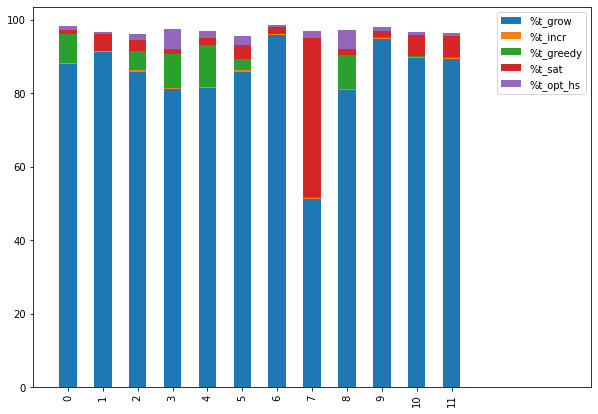

In [75]:
fig, ax = plt.subplots(figsize=(10,7))  
df_filt2.plot.bar(stacked=True, ax = ax)
ax.legend(loc=1)
ax.set_xlim([-1,15])
#N = 12
#ind = np.arange(N) 
#ax.set_xticks(ind)

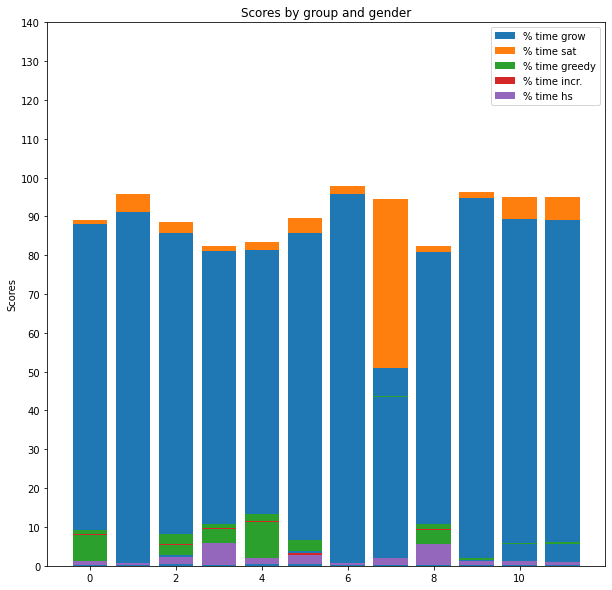

In [51]:
# graphing the instances




N = 12
ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

t_opt = proc_data['%t_opt']
t_non_opt = proc_data['%t_non_opt']

t_grow= proc_data['%t_grow']
t_incr= proc_data['%t_incr']
t_greedy= proc_data['%t_greedy']
t_sat= proc_data['%t_sat']
t_opt_hs= proc_data['%t_opt_hs']


p1 = plt.bar(ind, t_grow)
p2 = plt.bar(ind, t_sat, bottom=t_grow)
p3 = plt.bar(ind, t_greedy, bottom=t_sat)
p4 = plt.bar(ind, t_incr, bottom=t_greedy)
p5 = plt.bar(ind, t_opt_hs, bottom=t_incr)



plt.ylabel('Scores')
plt.title('Scores by group and gender')
#plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 150, 10))
plt.legend((p1[0], p2[0],p3[0], p4[0],p5[0]), ('% time grow', '% time sat', '% time greedy', '% time incr.', '% time hs'))

plt.show()

In [ ]:
f_size = 14
fig = plt.figure(figsize=(4, 3))
y_label = "Frequency"
# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(111)
ax1.set_xlabel("% Time spent in MIP solver",  fontsize=f_size)
ax1.set_ylabel(y_label,  fontsize=f_size)

axs=[ax1]
#solved_axs = [ax1, ax2, ax3]
#unsolved_axs = [ax4, ax5, ax6]

df.hist(
    column='t_opt', 
    bins=10, 
    ax = ax1,
    grid=False, 
    range = (0, 100),
    rwidth=0.9,
    )

df.hist(
    column='t_non_opt', 
    bins=10, 
    ax = ax1,
    color = 'green',
    range = (0, 100),
    grid=False, 
    rwidth=0.9)


    #a.set_ylim((0, 1000))
ax1.title.set_text('')

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
fig.savefig('/home/crunchmonster/Documents/VUB/02_Research/01_Conferences/2020/CP/DP/histogram3.pdf')
#plt.hist(x_solved_hs, bins = 10, range = (0,100))

In [48]:
qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [55]:
df_Filt = df[['steps_orig', 'steps_opt', 'steps_incr',  'steps_greedy',]]
print(df_Filt.to_latex(index=True))

\begin{tabular}{lrrrr}
\toprule
{} &  steps\_orig &  steps\_opt &  steps\_incr &  steps\_greedy \\
\midrule
0  &         552 &          1 &        2967 &           108 \\
1  &         717 &          3 &         184 &             5 \\
2  &         148 &          1 &         803 &            36 \\
3  &         201 &          1 &        1684 &            68 \\
4  &         182 &          1 &        1071 &            63 \\
5  &         151 &          1 &         287 &            20 \\
6  &          78 &          4 &          66 &             8 \\
7  &         409 &          7 &         155 &             9 \\
8  &         357 &          1 &        1798 &            70 \\
9  &           1 &          1 &           1 &             2 \\
10 &          42 &          2 &         167 &            11 \\
11 &         638 &          4 &         203 &             8 \\
12 &        1312 &          5 &         274 &             9 \\
\bottomrule
\end{tabular}



In [ ]:
df_Filt = df[['steps_greedy'], 'steps_opt', 'steps_incr']]